# Thesis random sweeps - 2Try - Fisher Info characterisation - Fixed noise

2/2

Same as 1try, but now fixed sigma_x=0.25 and sigma_baseline=0

Should give more useful samples for plots

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [177]:
with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_fisher2016_random_large_2try_310816.py

In [178]:
def avg_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(array, axis=-1))]
def avg_twice_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(utils.nanmean(array, axis=-1), axis=-1))]
def process_marginal_fi(array_name, array):
    # Marginal FI/Inv FI have (mean, std), just keep mean
    return [(array_name, utils.nanmean(array, axis=-1)[:, 0])]
def process_em_fits(array_name, array):
    emfits_all = utils.nanmean(array, axis=-1)
    outputs = [(array_name + "_" + colname, emfits_all[:, col_i])
            for col_i, colname in enumerate(['kappa',
                                             'target',
                                             'nontargets',
                                             'random',
                                             'LL',
                                             'bic'])
              ]
    outputs.append((array_name + '_fidelity', 1./utils.kappa_to_stddev(emfits_all[:, 0])**2.))
    
    return outputs
    
def construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions):
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    filter_data = None
    result_parameters_flat = None

    pandas_column_data = []

    for result_array_name, result_processing in pandas_columns_with_processing:
        # Extract data
        res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'])

        # Filter completed only
        if filter_data is None:
            repeats_completed = data_pbs.dict_arrays[result_array_name]['repeats_completed']
            filter_data = repeats_completed == (num_repetitions - 1)
        res_array = res_array[filter_data]

        # Keep parameters
        if result_parameters_flat is None:
            result_parameters_flat = np.array(data_pbs.dict_arrays[result_array_name]['parameters_flat'])
            result_parameters_flat = result_parameters_flat[filter_data]

        # Transform into list of columns for Pandas
        pandas_column_data.extend(result_processing['process'](result_processing['name'], res_array))

    # Add all parameters to Pandas columns
    for param_i, param_name in enumerate(parameter_names_sorted):
        pandas_column_data.append((param_name, result_parameters_flat[:, param_i]))
    
    df_out = pd.DataFrame.from_items(pandas_column_data)
    
    # Remove NaN
    df_out = df_out.dropna()
    
    return df_out

In [179]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

T_space = data_pbs.loaded_data['parameters_uniques']['T']
M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']

pandas_columns_with_processing = [
    ('result_all_precisions', dict(name='precision', process=avg_lastaxis)),
    ('result_FI_rc_curv', dict(name='fi_curv', process=avg_twice_lastaxis)),
    ('result_FI_rc_theo', dict(name='fi_theo', process=avg_twice_lastaxis)),
    ('result_FI_rc_theocov', dict(name='fi_theo_cov', process=avg_twice_lastaxis)),
    ('result_marginal_FI', dict(name='fi_marginal', process=process_marginal_fi)),
    ('result_marginal_inv_FI', dict(name='inv_fi_marginal', process=process_marginal_fi)),
    ('result_em_fits', dict(name='emfit', process=process_em_fits)),
]

df_all_fits = construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)
df_all_fits.loc[:, ('T')] = df_all_fits.loc[:, ('T')].astype(int)
df_all_fits.loc[:, ('M')] = df_all_fits.loc[:, ('M')].astype(int)

In [180]:
df_all_fits.describe()

,precision,fi_curv,fi_theo,fi_theo_cov,fi_marginal,inv_fi_marginal,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,T,M,ratio_conj
count,2825.000000,2825.000000,2825.000000,2825.000000,2825.000000,2.825000e+03,2825.000000,2825.000000,2825.000000,2.825000e+03,2825.000000,2825.000000,2825.000000,2825.000000,2825.000000,2825.000000
mean,130.257825,1757.167712,1478.681077,1446.439443,1524.860538,9.311062e+15,757.121591,0.623825,0.278282,9.789347e-02,2.127570,22.103285,756.611657,2.974867,294.941593,0.480277
std,502.694575,3039.322663,2953.729364,2927.132032,3052.377318,8.532490e+17,1781.558633,0.299407,0.227478,1.034379e-01,220.603787,446.994142,1781.562732,1.416867,171.841475,0.285362
min,0.160749,0.043394,0.001249,0.001243,0.001285,-1.044674e+19,0.582628,0.006877,0.000000,2.462402e-11,-366.941991,-1219.672600,0.392358,1.000000,4.000000,0.000000
25%,0.495389,72.061608,54.952361,53.281219,55.963311,6.266342e-04,26.414108,0.330129,0.050858,1.426972e-02,-156.921624,-248.000008,25.905766,2.000000,145.000000,0.238095
50%,1.318411,386.351177,297.510525,290.783272,305.216537,3.302837e-03,141.687950,0.664630,0.245522,6.917387e-02,-47.538726,125.606881,141.186465,3.000000,296.000000,0.471698
75%,7.386153,2108.233775,1532.184985,1481.532634,1577.109298,1.820221e-02,806.800323,0.917873,0.498741,1.510100e-01,134.260766,347.303326,806.300064,4.000000,437.000000,0.716846
max,8572.714285,24781.476761,27844.532436,27844.532436,28806.684869,4.350751e+19,60096.130911,1.000000,0.877564,9.931231e-01,617.783776,769.635103,60095.630909,5.000000,622.000000,1.000000


In [181]:
# Remove outliers
df_fits_filtered = df_all_fits[np.all(np.abs(spst.zscore(df_all_fits)) < 7, axis=1)]

In [182]:
df_fits_filtered.describe()

,precision,fi_curv,fi_theo,fi_theo_cov,fi_marginal,inv_fi_marginal,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,T,M,ratio_conj
count,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2.801000e+03,2801.000000,2801.000000,2801.000000,2.801000e+03,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000
mean,115.319887,1674.198180,1384.984517,1352.466625,1427.948649,3.641797e+13,693.020737,0.623388,0.280405,9.620694e-02,-0.137692,26.687524,692.510740,2.985005,294.199215,0.481980
std,413.174846,2794.001231,2627.213452,2595.840866,2714.612637,2.702185e+15,1255.471714,0.297781,0.227090,9.456836e-02,216.241353,438.264666,1255.477060,1.412618,170.616231,0.285259
min,0.160749,0.067779,0.003097,0.003088,0.004677,-5.314942e+16,0.582628,0.056608,0.000000,3.704123e-11,-366.923340,-1199.400640,0.392358,1.000000,4.000000,0.000000
25%,0.496175,72.289909,55.326753,53.477553,56.408745,6.408290e-04,26.258234,0.330591,0.055592,1.449180e-02,-156.654177,-241.444921,25.749840,2.000000,145.000000,0.240000
50%,1.305702,383.598485,297.052585,290.473625,302.534692,3.333799e-03,137.559396,0.662596,0.251697,6.949391e-02,-47.892564,126.768001,137.057866,3.000000,295.000000,0.473684
75%,6.912845,2082.728969,1499.530851,1457.894290,1540.108056,1.828091e-02,782.052285,0.913551,0.499371,1.507143e-01,131.192442,346.209369,781.552018,4.000000,434.000000,0.720000
max,3631.391776,19814.065938,21916.141015,21916.141015,22601.177347,1.209232e+17,10065.008271,1.000000,0.877564,6.814755e-01,607.647796,769.069050,10064.508250,5.000000,622.000000,1.000000


## -> Some stats

In [183]:
## Correlations
df_fits_filtered.corr()

,precision,fi_curv,fi_theo,fi_theo_cov,fi_marginal,inv_fi_marginal,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,T,M,ratio_conj
precision,1.000000,0.400553,0.459849,0.468876,0.458474,-0.003756,0.408801,0.347621,-0.342200,-0.272869,0.576850,-0.575859,0.408802,-0.387585,0.166920,-0.094065
fi_curv,0.400553,1.000000,0.982161,0.977658,0.982163,-0.008076,0.990024,-0.069691,0.029912,0.147618,0.567387,-0.563116,0.990024,-0.188214,0.517397,-0.502983
fi_theo,0.459849,0.982161,1.000000,0.999699,0.999971,-0.007107,0.984777,0.041369,-0.063319,0.021786,0.614640,-0.611028,0.984777,-0.263325,0.460072,-0.439783
fi_theo_cov,0.468876,0.977658,0.999699,1.000000,0.999660,-0.007024,0.981606,0.053755,-0.073718,0.007757,0.620596,-0.617054,0.981606,-0.272005,0.451628,-0.433871
fi_marginal,0.458474,0.982163,0.999971,0.999660,1.000000,-0.007091,0.984784,0.040628,-0.062601,0.022397,0.613519,-0.609907,0.984784,-0.262472,0.459684,-0.439802
inv_fi_marginal,-0.003756,-0.008076,-0.007107,-0.007024,-0.007091,1.000000,-0.000540,-0.017787,0.000407,0.055030,-0.022836,0.022779,-0.000538,0.014295,-0.022721,-0.018292
emfit_kappa,0.408801,0.990024,0.984777,0.981606,0.984784,-0.000540,1.000000,-0.041690,0.004955,0.119378,0.565812,-0.561903,1.000000,-0.208229,0.475639,-0.481932
emfit_target,0.347621,-0.069691,0.041369,0.053755,0.040628,-0.017787,-0.041690,1.000000,-0.970824,-0.817573,0.584099,-0.588783,-0.041689,-0.725482,0.100327,0.579844
emfit_nontargets,-0.342200,0.029912,-0.063319,-0.073718,-0.062601,0.000407,0.004955,-0.970824,1.000000,0.655640,-0.574605,0.578075,0.004953,0.647095,-0.219652,-0.582848
emfit_random,-0.272869,0.147618,0.021786,0.007757,0.022397,0.055030,0.119378,-0.817573,0.655640,1.000000,-0.459421,0.465835,0.119381,0.730540,0.211544,-0.426228


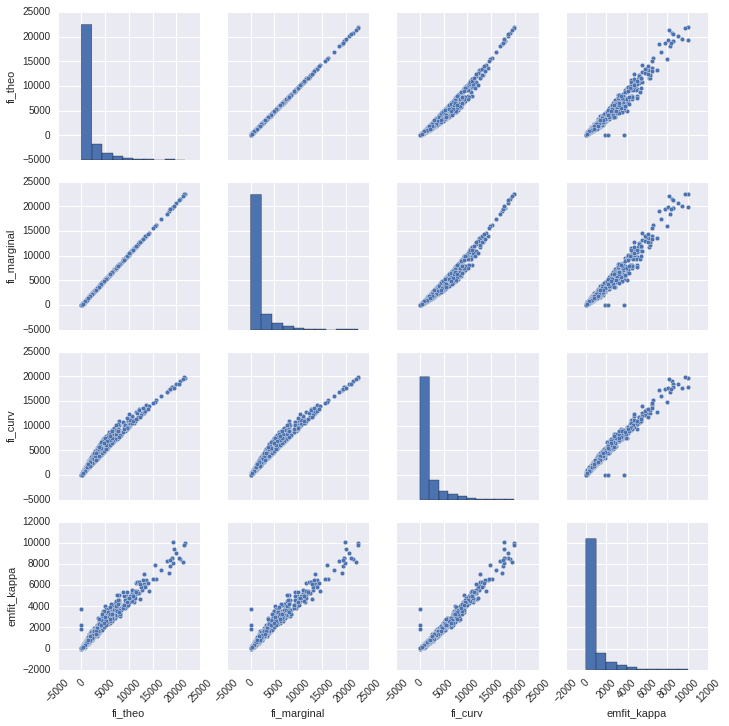

In [184]:
# Cross-correlation plots
g = sns.pairplot(df_fits_filtered,
             x_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
             y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
            )
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)


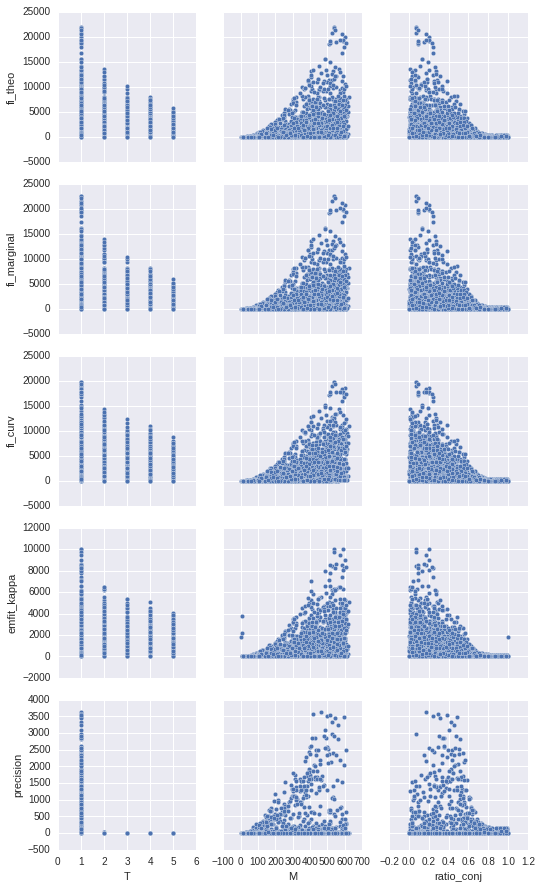

In [185]:
# Check parameters effects
sns.pairplot(df_fits_filtered,
             x_vars=parameter_names_sorted,
             y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa', 'precision']
            )

In [186]:
# for T, subdf in df_fits_filtered.groupby('T'):
#     g = sns.pairplot(subdf,
#                  x_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
#                  y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
#                 )
#     g.fig.suptitle("T : %d "% T, fontsize=30)
#     for ax in g.axes.flat:  
#         plt.setp(ax.get_xticklabels(), rotation=45)

## Quantize parameters

In [187]:
nQuantiles = 15
parameters = ['M', 'ratio_conj']

def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.qcut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, (param_name + "_qi")] = param_factored
    
    return df, param_qbins, param_qbins_middle

df_quantized, param_qbins, param_qbins_middle = df_add_quantize_parameters(df_fits_filtered, parameters, nQuantiles)

In [188]:
def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi

    return filter_dataframe(df, quantized_parameters_targets)

### trying quantized Dataframes

In [189]:
df_fixedM = filter_quantized_param(filter_dataframe(df_quantized, dict(T=1)), 
                                   dict(M=196), 
                                   param_qbins
                                  )

In [190]:
df_fixedM[['fi_theo', 'emfit_kappa', 'emfit_target', 'M', 'ratio_conj']].corr()

,fi_theo,emfit_kappa,emfit_target,M,ratio_conj
fi_theo,1.000000,0.997804,-0.608043,0.064698,-0.958018
emfit_kappa,0.997804,1.000000,-0.605735,0.060518,-0.963918
emfit_target,-0.608043,-0.605735,1.000000,-0.066683,0.555242
M,0.064698,0.060518,-0.066683,1.000000,-0.023260
ratio_conj,-0.958018,-0.963918,0.555242,-0.023260,1.000000


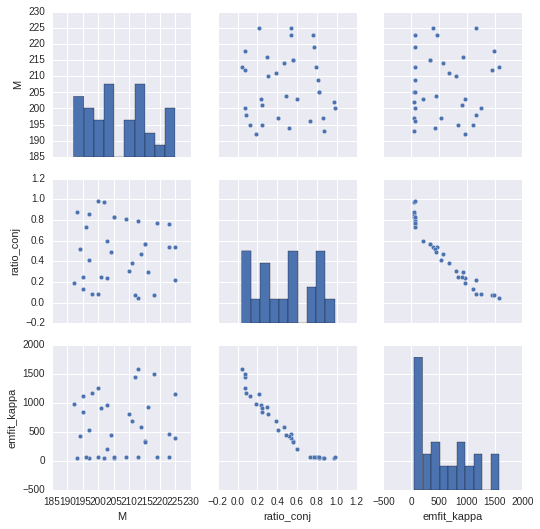

In [191]:
sns.pairplot(df_fixedM,
             vars=['M', 'ratio_conj', 'emfit_kappa']
            )

In [192]:
df_Mratio_effect = df_quantized.pivot_table(index='M_qi', columns='ratio_conj_qi', aggfunc='mean')

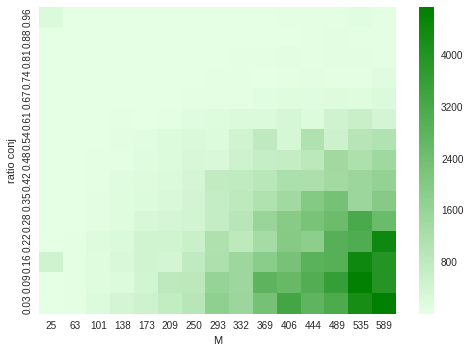

In [193]:
cmap = sns.light_palette("green", as_cmap=True)

ax = sns.heatmap(df_Mratio_effect['emfit_kappa'].T, 
                 yticklabels=["%.2f" % v for v in param_qbins_middle['ratio_conj']],
                 xticklabels=["%d" % v for v in param_qbins_middle['M']],
                 cmap=cmap
                )
ax.invert_yaxis()
ax.set_ylabel("ratio conj")
ax.set_xlabel("M")

(<matplotlib.axes._subplots.AxesSubplot at 0x7f78ff94fe10>,
 <matplotlib.image.AxesImage at 0x7f78ff889d50>)

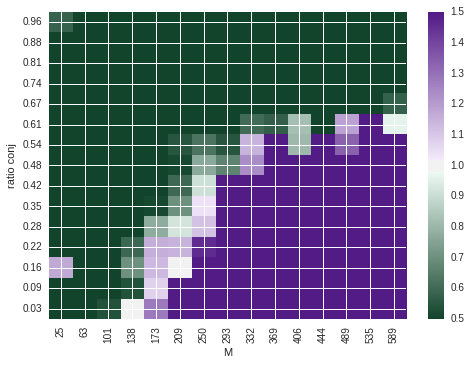

In [194]:
kappa_evolution = df_Mratio_effect['emfit_kappa']/400
kappa_evolution[kappa_evolution < 0.5] = 0.5
kappa_evolution[kappa_evolution > 1.5] = 1.5
cmap = sns.diverging_palette(145, 280, s=85, l=25, n=10, as_cmap=True)
utils.pcolor_2d_data(kappa_evolution, 
                     x=param_qbins_middle['M'],
                     y=param_qbins_middle['ratio_conj'], 
                     xlabel='M', 
                     xlabel_format="%d",
                     ylabel='ratio conj', 
                     vmin=0.5,
                     vmax=1.5,
                     cmap=cmap
                    )

(<matplotlib.axes._subplots.AxesSubplot at 0x7f78ff7dc450>,
 <matplotlib.image.AxesImage at 0x7f78ff6f1110>)

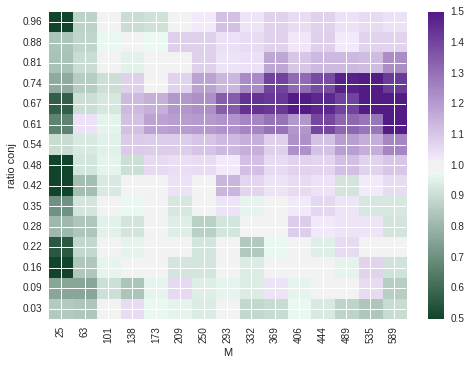

In [195]:
fi_kappa_ratio = df_Mratio_effect['fi_theo']/(2*df_Mratio_effect['emfit_kappa'])
fi_kappa_ratio[fi_kappa_ratio > 1.5] = 1.5
fi_kappa_ratio[fi_kappa_ratio < 0.5] = 0.5

cmap = sns.diverging_palette(145, 280, s=85, l=25, n=7, as_cmap=True)
utils.pcolor_2d_data(fi_kappa_ratio, 
                     x=param_qbins_middle['M'],
                     y=param_qbins_middle['ratio_conj'], 
                     xlabel='M', 
                     xlabel_format="%d",
                     ylabel='ratio conj', 
                     vmin=0.5,
                     vmax=1.5,
                     cmap=cmap
                    )